In [1]:
using OrdinaryDiffEq, Sundials, DiffEqDevTools, DiffEqOperators
using IterativeSolvers: gmres!
using LinearAlgebra, SparseArrays
using Plots; gr();

# Burgers equation

The one-dimensional [Burgers equation](https://en.wikipedia.org/wiki/Burgers%27_equation) is a frequently used toy nonlinear PDE model. The defining feature of the equation is its ability to develop discontinuities (shock waves) from continuous initial data.

The continuous Burgers equation is

$$ u_t = \epsilon u_{xx} - uu_x, \quad x\in [0,1], \, t\in [0,1]$$

with Dirichlet boundary conditions and smooth initial data. For numerical discretization, we rewrite the nonlinear term as $-\frac12(u^2)_x$ and use central differencing for the spatial derivatives, which we express as sparse matrices.

To accurately capture the shock in the solution, we need to use a fine mesh. Since the spectral radius of the laplacian grows like $O(N^2)$, the linear term will become very stiff and make it difficult for explicit methods to perform.

TODO: 

* After updates to DiffEqOperators, benchmark again using matrix-free derivative operators.

* Add a section to compare performance with explicit and implicit methods

In [2]:
# Define the linear and nonlinear terms
function lin_term(N, ϵ)
    dx = 1/(N + 1)
    d = -2 * ones(N) # main diagonal
    du = ones(N - 1) # off diagonal
    DiffEqArrayOperator((ϵ/dx^2) * spdiagm(-1 => du, 0 => d, 1 => du))
    # spdiagm is more efficient than BandedMatrix: faster ishermitian and mul!
end

function nl_term(N)
    # Construct a light-weight function object via closure
    dx = 1/(N + 1)
    du = ones(N - 1) # super diagonal
    dl = -ones(N - 1) # lower diagonal
    D = (-1/(4*dx)) * spdiagm(-1 => dl, 1 => du)
    
    tmp = zeros(N)
    function (du,u,p,t)
        @. tmp = u^2
        mul!(du, D, tmp)
    end
end

# Construct the problem
function burgers(N, ϵ)
    f1 = lin_term(N, ϵ)
    f2 = nl_term(N)
    dx = 1 / (N + 1)
    xs = (1:N) * dx
    
    μ0 = 0.3; σ0 = 0.05
    f0 = x -> exp(-(x - μ0)^2 / (2 * σ0^2))
    u0 = f0.(xs)
    prob = SplitODEProblem(f1, f2, u0, (0.0, 1.0))
    xs, prob
end;

Note that we have defined the linear term as a `DiffEqArrayOperator` and the nonlinear term as a reguler `(du,u,p,t)` function. This is because we want to pose the ODE as a semilinear system via `SplitODEProblem`, which could utilize special solvers such as the exponential Runge-Kutta methods. Some IMEX methods can also take advantage of this special structure, while regular split methods can also expect good performance (see [Split ODE Solvers](http://docs.juliadiffeq.org/latest/solvers/split_ode_solve.html) for an overview of these methods).

### Reference solution using `Vern9`

In [3]:
xs, prob = burgers(200, 1e-3)
sol = solve(prob, Vern9(); abstol=1e-14, reltol=1e-14)
test_sol = TestSolution(sol);

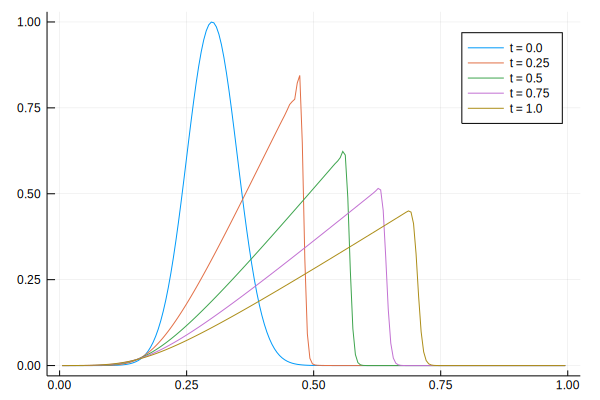

In [4]:
tslices = [0.0 0.25 0.50 0.75 1.00]
ys = hcat((sol(t) for t in tslices)...)
labels = ["t = $t" for t in tslices]
plot(xs, ys, label=labels)

In [5]:
# Linear solvers
# Default linsolve uses lu!, which is incompatible with SparseMatrixCSC
const LS_Dense = LinSolveFactorize(lu)

# GMRES solver that shares the same default as the solver used by ARKODE
# (5 basis vector, no restarts)
function LS_GMRES(::Type{Val{:init}}, f, x)
    function (x, A, b, update_matrix=false)
        gmres!(x, A, b; initially_zero=false, maxiter=5)
    end
end;

## High tolerances

Testing low order, high tolerance solvers.

TODO: 

* Use either `Rosenbrock23` or `TRBDF2` as a reference. Both errors when applied to the problem; need to transform to regular form?

* Should probably be more careful about error calculation. Need to focus on the resolution of the shock instead of global mean squared error.

* Experiment with varying `iop` in Krylov methods.

### In-family comparisons

1. **IMEX methods (dense linear solver)**

In [6]:
abstols = 0.1 .^ (5:8) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (1:4)
multipliers = 0.5 .^ (0:3)
setups = [Dict(:alg => IMEXEuler(linsolve=LS_Dense), :dts => 1e-3 * multipliers),
          Dict(:alg => CNAB2(linsolve=LS_Dense), :dts => 5e-3 * multipliers),
          Dict(:alg => CNLF2(linsolve=LS_Dense), :dts => 5e-3 * multipliers),
          Dict(:alg => SBDF2(linsolve=LS_Dense), :dts => 1e-3 * multipliers)]
labels = ["IMEXEuler" "CNAB2" "CNLF2" "SBDF2"]
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

IMEXEuler
CNAB2
CNLF2
SBDF2
 85.732821 seconds (61.14 M allocations: 63.369 GiB, 20.35% gc time)


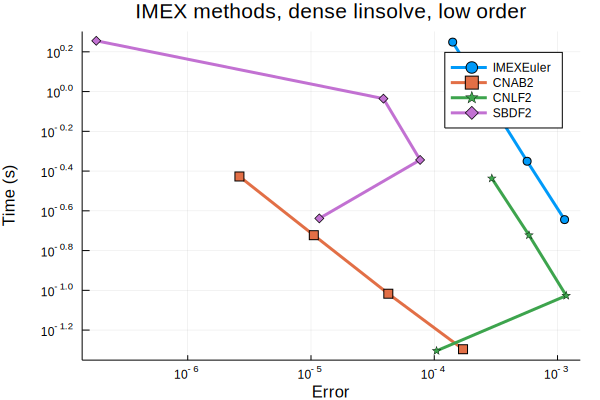

In [7]:
plot(wp, label=labels, markershape=:auto, title="IMEX methods, dense linsolve, low order")

2. **IMEX methods (Krylov linear solver)**

In [8]:
abstols = 0.1 .^ (5:8) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (1:4)
multipliers = 0.5 .^ (0:3)
setups = [Dict(:alg => IMEXEuler(linsolve=LS_GMRES), :dts => 1e-3 * multipliers),
          Dict(:alg => CNAB2(linsolve=LS_GMRES), :dts => 5e-3 * multipliers),
          Dict(:alg => CNLF2(linsolve=LS_GMRES), :dts => 5e-3 * multipliers),
          Dict(:alg => SBDF2(linsolve=LS_GMRES), :dts => 1e-3 * multipliers)]
labels = ["IMEXEuler" "CNAB2" "CNLF2" "SBDF2"]
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

IMEXEuler
CNAB2
CNLF2
SBDF2
 31.755324 seconds (40.59 M allocations: 11.192 GiB, 47.31% gc time)


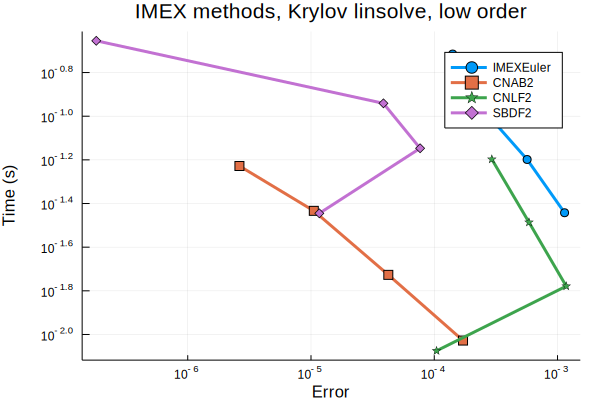

In [9]:
plot(wp, label=labels, markershape=:auto, title="IMEX methods, Krylov linsolve, low order")

3. **ExpRK methods**

In [10]:
abstols = 0.1 .^ (5:8) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (1:4)
multipliers = 0.5 .^ (0:3)
setups = [Dict(:alg => NorsettEuler(), :dts => 1e-3 * multipliers),
          Dict(:alg => NorsettEuler(krylov=true, m=5), :dts => 1e-3 * multipliers),
          Dict(:alg => NorsettEuler(krylov=true, m=20), :dts => 1e-3 * multipliers),
          Dict(:alg => ETDRK2(), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK2(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK2(krylov=true, m=20), :dts => 1e-2 * multipliers)]
labels = hcat("NorsettEuler (caching)", "NorsettEuler (m=5)", "NorsettEuler (m=20)",
              "ETDRK2 (caching)", "ETDRK2 (m=5)", "ETDRK2 (m=20)")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

NorsettEuler (caching)
NorsettEuler (m=5)
NorsettEuler (m=20)
ETDRK2 (caching)
ETDRK2 (m=5)
ETDRK2 (m=20)
144.556187 seconds (59.01 M allocations: 114.417 GiB, 22.54% gc time)


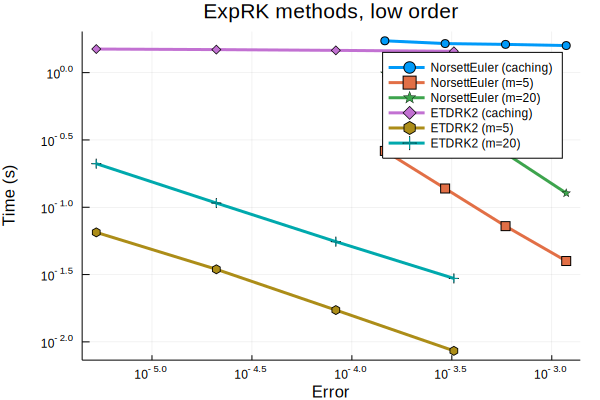

In [11]:
plot(wp, label=labels, markershape=:auto, title="ExpRK methods, low order")

Note that for caching ExpRK methods, the solution time does not vary much with `dt`. This is because most of the time is spent on precomputing the operators rather than actual time stepping.

### Between familiy comparisons

In [12]:
abstols = 0.1 .^ (5:8) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (1:4)
multipliers = 0.5 .^ (0:3)
setups = [Dict(:alg => CNAB2(linsolve=LS_Dense), :dts => 5e-3 * multipliers),
          Dict(:alg => CNAB2(linsolve=LS_GMRES), :dts => 5e-3 * multipliers),
          Dict(:alg => ETDRK2(krylov=true, m=5), :dts => 1e-2 * multipliers)]
labels = ["CNAB2 (dense linsolve)" "CNAB2 (Krylov linsolve)" "ETDRK2 (m=5)"]
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

CNAB2 (dense linsolve)
CNAB2 (Krylov linsolve)
ETDRK2 (m=5)
 16.820763 seconds (5.25 M allocations: 6.460 GiB, 63.24% gc time)


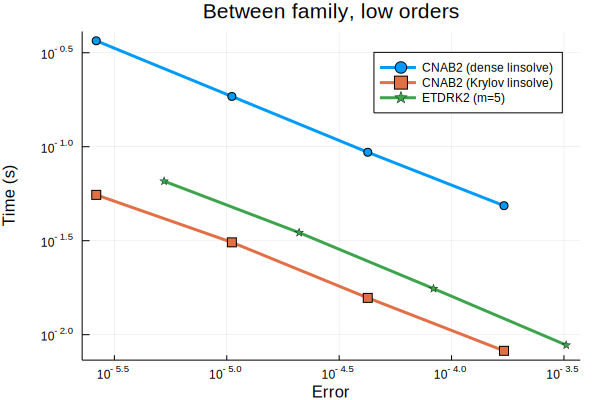

In [13]:
plot(wp, label=labels, markershape=:auto, title="Between family, low orders")

The Krylov methods clearly outperform IMEX with dense solvers and `CNAB2` performs slightly better than `ETDRK2`.

## Low tolerances

Testing medium order, low tolerance solvers.

### In-family comparisons

1. **IMEX methods (dense linear solver)**

In [14]:
abstols = 0.1 .^ (7:13)
reltols = 0.1 .^ (4:10)
setups = [Dict(:alg => KenCarp3(linsolve=LS_Dense)),
          Dict(:alg => KenCarp4(linsolve=LS_Dense)),
          Dict(:alg => KenCarp5(linsolve=LS_Dense)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=3, linear_solver=:Dense)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=4, linear_solver=:Dense)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=5, linear_solver=:Dense))]
labels = hcat("KenCarp3", "KenCarp4", "KenCarp5", "ARKODE3", "ARKODE4", "ARKODE5")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

KenCarp3
KenCarp4
KenCarp5
ARKODE3
ARKODE4
ARKODE5
269.400250 seconds (92.74 M allocations: 69.380 GiB, 14.93% gc time)


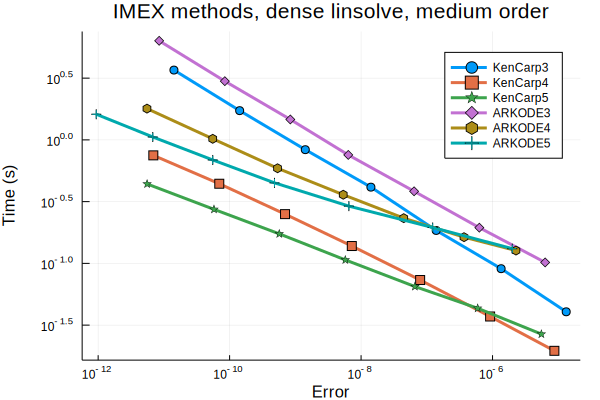

In [15]:
plot(wp, label=labels, markershape=:auto, title="IMEX methods, dense linsolve, medium order")

2. **IMEX methods (Krylov linear solver)**

In [16]:
abstols = 0.1 .^ (7:13)
reltols = 0.1 .^ (4:10)
setups = [Dict(:alg => KenCarp3(linsolve=LS_GMRES)),
          Dict(:alg => KenCarp4(linsolve=LS_GMRES)),
          Dict(:alg => KenCarp5(linsolve=LS_GMRES)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=3, linear_solver=:GMRES)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=4, linear_solver=:GMRES)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=5, linear_solver=:GMRES))]
labels = ["KenCarp3" "KenCarp4" "KenCarp5" "ARKODE3" "ARKODE4" "ARKODE5"]
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

KenCarp3


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages

KenCarp4


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages

KenCarp5


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages/DiffEqBase/HD6bO/src/integrator_interface.jl:134
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/xingjian.guo/.julia/packages

ARKODE3
ARKODE4
ARKODE5
735.959418 seconds (1.76 G allocations: 1.344 TiB, 20.77% gc time)


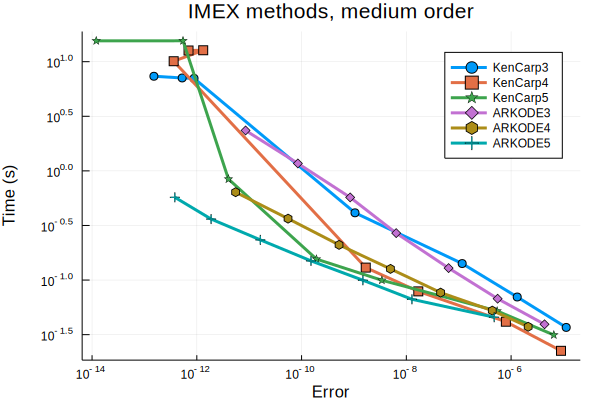

In [17]:
plot(wp, label=labels, markershape=:auto, title="IMEX methods, medium order")

In [18]:
abstols = 0.1 .^ (7:11) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (4:8)
multipliers = 0.5 .^ (0:4)
setups = [Dict(:alg => ETDRK3(), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK3(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK4(), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK4(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => HochOst4(), :dts => 1e-2 * multipliers),
          Dict(:alg => HochOst4(krylov=true, m=5), :dts => 1e-2 * multipliers)]
labels = hcat("ETDRK3 (caching)", "ETDRK3 (m=5)", "ETDRK4 (caching)",
              "ETDRK4 (m=5)", "HochOst4 (caching)", "HochOst4 (m=5)")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

ETDRK3 (caching)
ETDRK3 (m=5)
ETDRK4 (caching)
ETDRK4 (m=5)
HochOst4 (caching)
HochOst4 (m=5)
386.783355 seconds (74.96 M allocations: 371.078 GiB, 16.57% gc time)


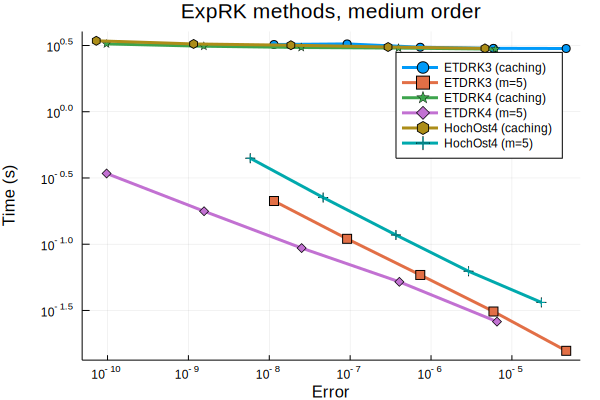

In [19]:
plot(wp, label=labels, markershape=:auto, title="ExpRK methods, medium order")

### Between family comparisons

In [20]:
abstols = 0.1 .^ (7:11)
reltols = 0.1 .^ (4:8)
multipliers = 0.5 .^ (0:4)
setups = [Dict(:alg => KenCarp5(linsolve=LS_Dense)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=5, linear_solver=:Dense)),
          Dict(:alg => KenCarp5(linsolve=LS_GMRES)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=5, linear_solver=:GMRES)),
          Dict(:alg => ETDRK3(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK4(krylov=true, m=5), :dts => 1e-2 * multipliers)]
labels = hcat("KenCarp5 (dense linsolve)", "ARKODE (dense linsolve)", "KenCarp5 (Krylov linsolve)",
              "ARKODE (Krylov linsolve)", "ETDRK3 (m=5)", "ETDRK4 (m=5)")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=5, error_estimate=:l2,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

KenCarp5 (dense linsolve)
ARKODE (dense linsolve)
KenCarp5 (Krylov linsolve)
ARKODE (Krylov linsolve)
ETDRK3 (m=5)
ETDRK4 (m=5)
 64.022140 seconds (46.63 M allocations: 22.860 GiB, 47.13% gc time)


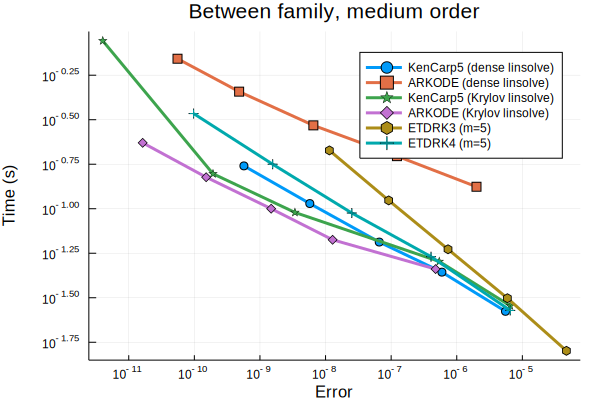

In [21]:
plot(wp, label=labels, markershape=:auto, title="Between family, medium order")

`ARKODE` with Krylov linear solver (GMRES) is the winner here.

# Burgers equation (standard formulation)

TODO: use regular ODE (non-semilinear) and compare regular implicit methods with Exprb methods and EPIRK methods.

## Environment information

In [22]:
versioninfo()
using Pkg
println("OrdinaryDiffEq: ", Pkg.installed()["OrdinaryDiffEq"])
println("Sundials: ", Pkg.installed()["Sundials"])

Julia Version 1.0.2
Commit d789231e99 (2018-11-08 20:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, haswell)
OrdinaryDiffEq: 4.18.0
Sundials: 2.6.0
